In [23]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../')
from my_utils.custom_linear_regression import CustomLinearRegression

In [30]:

data = load_diabetes(as_frame=True)

features = data.data
target = data.target

X_train, X_test, y_train, y_test  = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=True)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [31]:
from sklearn.model_selection import KFold

def kfold( X, y, model_class, n_splits=5, **model_kwargs):
    """
        Perform K-Fold cross-validation on a given model and dataset.

        Parameters
        ----------
        X : pd.DataFrame or np.ndarray
            Feature matrix of shape (n_samples, n_features).

        y : pd.Series or np.ndarray
            Target vector of shape (n_samples,).

        model_class : class
            A class implementing a `fit` and `predict` method (e.g., CustomLinearRegression, SVR).

        n_splits : int, default=5
            Number of folds for cross-validation.

        **model_kwargs : dict
            Additional keyword arguments to initialize the model.

        Returns
        -------
        mean_mse_score : float
            The average mean squared error across all folds.

        mean_r2_score : float
            The average R² score across all folds.

        mse_change_percent : float
            Percentage improvement in mean squared error compared to predicting the mean of `y`.

        r2_scores : list of float
            List of R² scores for each fold.

        mse_scores : list of float
            List of MSE values for each fold.

        Notes
        -----
        - Uses scikit-learn's `KFold` for splitting the data.
        - Computes baseline MSE using the variance of `y`.
        - Useful for model evaluation and hyperparameter tuning.

        Examples
        --------
        >>> lr_params = {'learning_rate': 0.01, 'regularize': True, 'regularization_strength': 0.1}
        >>> mean_mse, mean_r2, mse_change, r2s, mses = kfold(X, y, CustomLinearRegression, n_splits=5, **lr_params)

        >>> svr_params = {'kernel':'linear', 'C':1}
        >>> mean_mse, mean_r2, mse_change, r2s, mses = kfold(X, y, SVR, n_splits=5, **svr_params)
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    r2_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = ( X.iloc[train_index], X.iloc[val_index] ) if isinstance(X, pd.DataFrame) else ( X[train_index], X[val_index] )
        y_train, y_val = ( y.iloc[train_index], y.iloc[val_index] ) if isinstance(y, pd.Series) else ( y[train_index], y[val_index] )

        model = model_class(**model_kwargs).fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)

    mean_mse_score = np.mean(mse_scores)
    baseline_mse = np.mean((y - y.mean())**2)  # or just variance of y
    mse_change_percent  = np.round( (baseline_mse - mean_mse_score) / baseline_mse * 100,  0)

    mean_r2_score = np.mean(r2_scores)

    print(f"\nOn average, across all folds, the variance in the validation data that the model explains is: {mean_r2_score * 100:.2f}%")
    print(f"Compared to naively just predicting the mean, the model's mean squared error changed by: {mse_change_percent:.0f}%.\n")

    return mean_mse_score, mean_r2_score, mse_change_percent, r2_scores, mse_scores

In [33]:
n_splits = 5

lr_custom_params = {'learning_rate': 0.01, 'regularize': True, 'regularization_strength': 1, 'verbose': False}
mean_mse_score, mean_r2_score, mse_change_percent, r2_scores, mse_scores = kfold(X_train, y_train, n_splits=n_splits, **lr_custom_params,model_class=CustomLinearRegression)

param = {'alpha': 0.01}
mean_mse_score_ridge, mean_r2_score_ridge, mse_change_percent_ridge, r2_scores_ridge, mse_scores_ridge = kfold(X_train, y_train, n_splits=n_splits, **param,
                                                                             model_class=Ridge)

Early stopping at iteration: 801 due to ΔCost being less 0.001

On average, across all folds, the variance in the validation data that the model explains is: 47.17%
Compared to naively just predicting the mean, the model's mean squared error changed by: 48%.


On average, across all folds, the variance in the validation data that the model explains is: 46.88%
Compared to naively just predicting the mean, the model's mean squared error changed by: 47%.



In [34]:
pd.DataFrame({'MSE scores (Linear Regression)': mse_scores, 'MSE scores (Ridge)': mse_scores_ridge,
              'R2 scores (Linear Regression)': r2_scores, 'R2 scores (Ridge)': r2_scores_ridge,
              }).round(3)

,MSE scores (Linear Regression),MSE scores (Ridge),R2 scores (Linear Regression),R2 scores (Ridge)
0,3113.110,3121.347,0.515,0.514
1,2666.595,2595.289,0.476,0.490
2,3349.542,3654.514,0.515,0.471
3,3373.188,3324.144,0.423,0.431
4,3503.461,3451.259,0.430,0.438


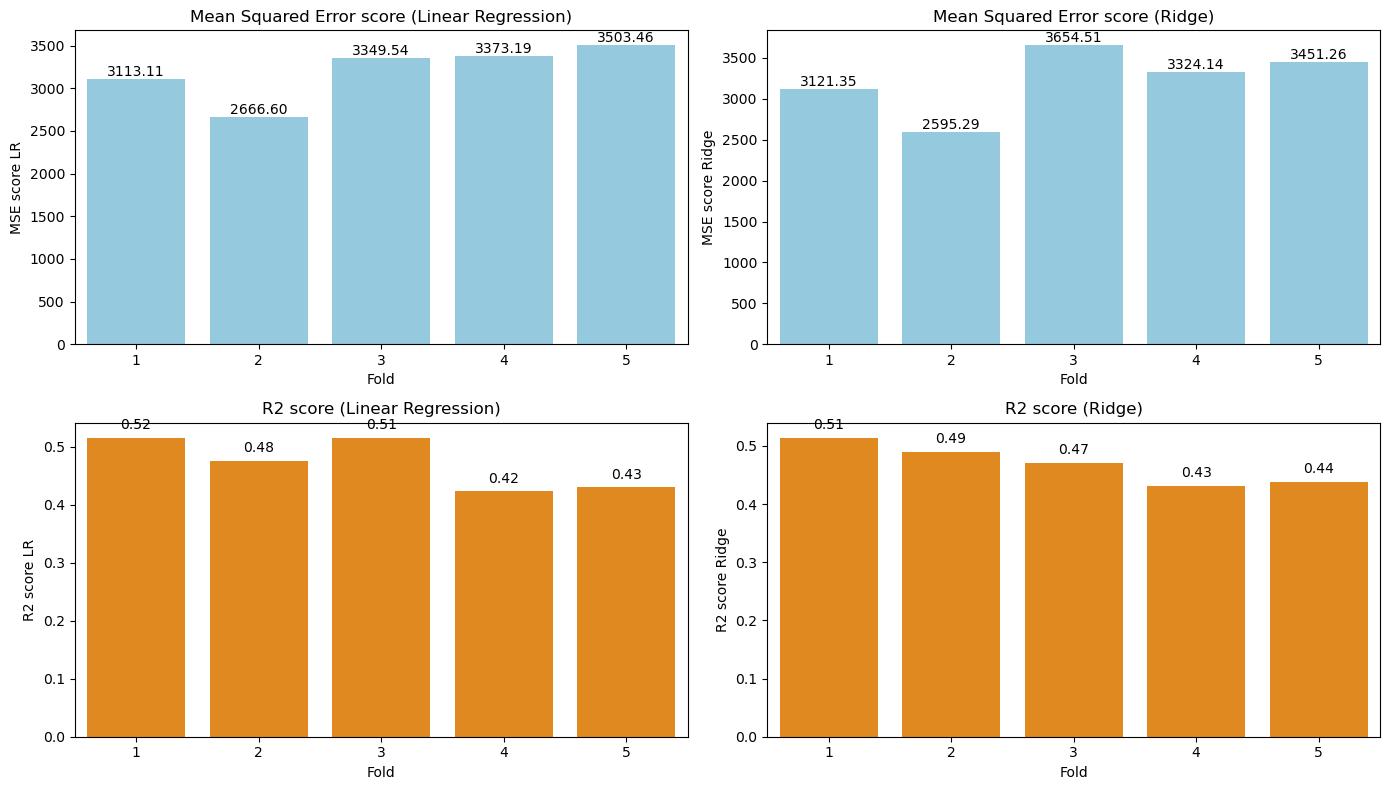

In [36]:
figure, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for ax, (score_value, score_name) in zip(
                                            axes,
                                            zip([mse_scores, mse_scores_ridge, r2_scores, r2_scores_ridge],
                                                ['MSE score LR', 'MSE score Ridge', 'R2 score LR', 'R2 score Ridge'])
                                        ):
    color = 'skyblue' if 'MSE' in score_name else 'darkorange'

    sns.barplot(y=score_value, x=list(range(1, n_splits + 1)), ax=ax, color=color)
    
    for i, score in enumerate(score_value):
        ax.text(i, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel(f'{score_name}')
    ax.set_xlabel('Fold')

    title = score_name.replace('MSE', 'Mean Squared Error')
    title = title.replace('LR', '(Linear Regression)')
    title = title.replace('Ridge', '(Ridge)')
    ax.set_title(title)

figure.tight_layout()